In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pathlib
import random
from PIL import Image
import os
import shutil
from tqdm import tqdm
from timeit import default_timer as timer
import glob

In [2]:
data_path="/kaggle/input/animals10/raw-img"

classes_dict = { 
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel",
}

classes = ["dog", "horse", "elephant", "butterfly", "chicken", "cat", "cow", "sheep", "spider", "squirrel",]

data = {
    "path":[],
    "label":[],
    "label_id":[]
}

BATCH_SIZE = 16

device = "cuda" if torch.cuda.is_available() else 'cpu'

In [3]:
for ind, (label_it, label_en) in enumerate(classes_dict.items()):
    paths = glob.glob(f'{data_path}/{label_it}/*.jpeg')

    data["path"].extend(paths)
    data["label"].extend([label_en] * len(paths))
    data["label_id"].extend([ind] * len(paths))

df_data = pd.DataFrame(data)
df_data.head()

,path,label,label_id
0,/kaggle/input/animals10/raw-img/cane/OIP-6p-HH...,dog,0
1,/kaggle/input/animals10/raw-img/cane/OIP-A1GkR...,dog,0
2,/kaggle/input/animals10/raw-img/cane/OIP-GZmwq...,dog,0
3,/kaggle/input/animals10/raw-img/cane/OIP-Yj0uE...,dog,0
4,/kaggle/input/animals10/raw-img/cane/OIP-bbrbp...,dog,0


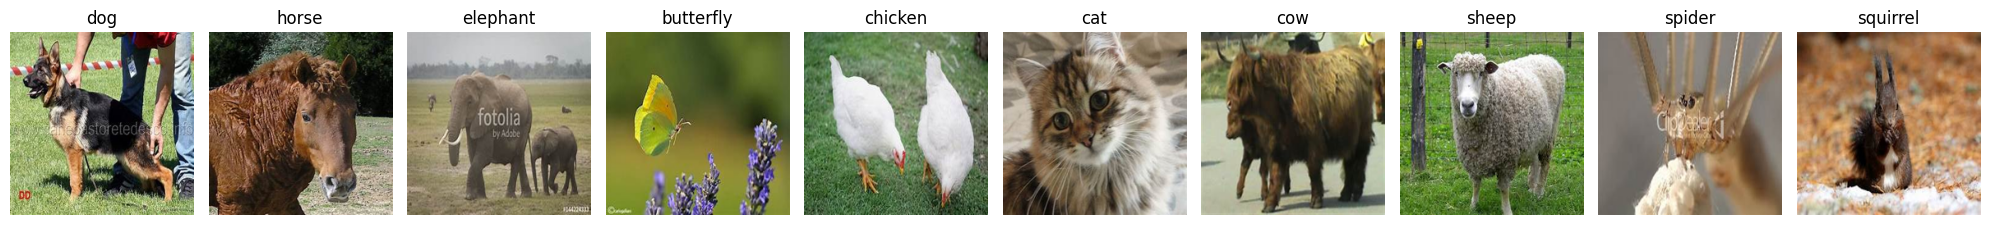

In [4]:
plt.figure(figsize = (20, 7))

for idx, i in enumerate(df_data.label.unique()):
    plt.subplot(1, 10, idx + 1)
    df = df_data[df_data['label'] == i].reset_index(drop=True)
    
    image_path = df.loc[random.randint(0, len(df) - 1), 'path']
    img = Image.open(image_path)
    img = img.resize((224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    
plt.tight_layout()
plt.show()

In [5]:
train_df, test_df = train_test_split(df_data, test_size= 0.2)

train_df, test_df = train_df.reset_index(), test_df.reset_index()
train_df.shape, test_df.shape

((19367, 4), (4842, 4))

In [6]:
# # train_df.head()

# paths = test_df.path.values

# dir_path = pathlib.Path('/kaggle/working/test_img')
# dir_path.mkdir(parents=True,
#                         exist_ok=True)
# for image_path in paths:
#     shutil.copy(image_path, dir_path)

# shutil.make_archive("test_img", "zip", "/kaggle/working")

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [8]:
class SimpleDataset(Dataset):
    def __init__(self, df, transforms=None, split="train", path_col = "path", label_col="label"):
        super().__init__()
        self.df = df
        self.transforms = transforms
        self.path_col = path_col
        self.label_col = label_col
    
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.df.loc[index, self.path_col]
        label = self.df.loc[index, self.label_col]
        
        img = Image.open(img_path) 
        
        if self.transforms:
            return self.transforms(img), label
        return img, label

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample :
            residual = self.downsample(residual)
        out = out + residual
        out = self.relu(out)
        
        return out

In [10]:
class ResNet(nn.Module): 
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.conv2_x = self._make_layer(block, 64, layers[0], stride = 1)
        self.conv3_x = self._make_layer(block, 128, layers[1], stride = 2)
        self.conv4_x = self._make_layer(block, 256, layers[2], stride = 2)
        self.conv5_x = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes) # original resnet fc
#         self.fc = nn.Sequential(
#                         nn.Linear(512, 256),
#                         nn.ReLU(),
#                         nn.Linear(256, num_classes))
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [11]:
def check_model_output(model, train_dataloader):
    img_batch, label_batch = next(iter(train_dataloader))

    img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
    print(f"Single image shape: {img_single.shape}\n")

    model.eval()
    with torch.inference_mode():
        pred = model(img_single.to(device))

    print(f"Output logits:\n{pred}\n")
    print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
    print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
    print(f"Actual label:\n{label_single}")

In [12]:
def train_step(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    correct = 0
    
    model.train()
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
#         if batch % 500 == 0:
#             loss, current = loss.item(), batch * X.shape[0] + len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        del X, y, pred
        torch.cuda.empty_cache()
    
    train_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
#     print(f"Train Loss: {loss.item():>7f}")
    
    return train_loss, 100*correct

In [13]:
def test_step(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader, total = num_batches):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            del X, y, pred

    test_loss /= num_batches
    correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, 100*correct

In [14]:
def train_test(model, epochs, train_dataloader, test_dataloader, loss_fn, optimizer, save_steps=5, save_dir="models"):
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    os.makedirs(save_dir, exist_ok=True)
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        train_loss, train_acc = train_step(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_acc = test_step(test_dataloader, model, loss_fn)
        
        if (epoch % save_steps == 0 and epoch > 0) or epoch == epochs -1:
            torch.save(model.state_dict(), f"{save_dir}/{epoch}")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        print(f"Train Loss: \n Avg loss: {train_loss:>7f}\tAccuracy: {(test_acc):>0.1f}%")
        print(f"Test Error: \n Avg loss: {test_loss:>7f}\tAccuracy: {(test_acc):>0.1f}% \n")
    
    return results

In [15]:
def show_predictions(model, test_dataloader, num_images=8):
    images, labels = next(iter(test_dataloader))
    model.eval()
    pred_labels = model(images.to(device))
    pred_labels = torch.argmax(torch.softmax(pred_labels, dim=1), dim=1).to("cpu")
    
    print(f"Actual Labels: {labels} \nPredicted Labels: {pred_labels} \n\nImages and their predictions \n")
    
    images = images.permute([0, 2, 3, 1])
    
    plt.figure(figsize = (20, 10))
    for i in range(num_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(classes[pred_labels[i]])

In [16]:
num_classes = 10 
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()

In [17]:
train_data = SimpleDataset(train_df, transforms=train_transforms, path_col="path", label_col="label_id")
test_data = SimpleDataset(test_df, transforms=test_transforms, path_col="path", label_col="label_id")

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

In [18]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 3, 224, 224])
Label shape: torch.Size([16])


## ResNet-18

In [19]:
net_18 = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=num_classes)    
net_18 = net_18.to(device)
    
optimizer_18 = torch.optim.Adam(net_18.parameters(), lr=0.001)

In [20]:
# check_model_output(net_18, train_dataloader)

In [21]:
train_test(net_18, 15, train_dataloader, test_dataloader, loss_fn, optimizer_18, save_dir="resnet_18") # 10

Epoch: 0


100%|██████████| 303/303 [00:57<00:00,  5.26it/s]

Train Loss: 
 Avg loss: 2.035570	Accuracy: 36.0%
Test Error: 
 Avg loss: 1.832277	Accuracy: 36.0% 

Epoch: 1



100%|██████████| 303/303 [00:19<00:00, 15.68it/s]

Train Loss: 
 Avg loss: 1.746827	Accuracy: 45.3%
Test Error: 
 Avg loss: 1.611036	Accuracy: 45.3% 

Epoch: 2



100%|██████████| 303/303 [00:23<00:00, 13.13it/s]

Train Loss: 
 Avg loss: 1.553486	Accuracy: 51.3%
Test Error: 
 Avg loss: 1.412256	Accuracy: 51.3% 

Epoch: 3



100%|██████████| 303/303 [00:19<00:00, 15.83it/s]

Train Loss: 
 Avg loss: 1.396166	Accuracy: 54.3%
Test Error: 
 Avg loss: 1.343357	Accuracy: 54.3% 

Epoch: 4



100%|██████████| 303/303 [00:18<00:00, 16.16it/s]

Train Loss: 
 Avg loss: 1.269594	Accuracy: 60.7%
Test Error: 
 Avg loss: 1.176818	Accuracy: 60.7% 

Epoch: 5



100%|██████████| 303/303 [00:16<00:00, 18.18it/s]

Train Loss: 
 Avg loss: 1.174935	Accuracy: 66.0%
Test Error: 
 Avg loss: 0.994402	Accuracy: 66.0% 

Epoch: 6



100%|██████████| 303/303 [00:18<00:00, 16.73it/s]

Train Loss: 
 Avg loss: 1.109774	Accuracy: 66.9%
Test Error: 
 Avg loss: 0.981158	Accuracy: 66.9% 

Epoch: 7



100%|██████████| 303/303 [00:17<00:00, 17.22it/s]

Train Loss: 
 Avg loss: 1.032446	Accuracy: 68.6%
Test Error: 
 Avg loss: 0.945311	Accuracy: 68.6% 

Epoch: 8



100%|██████████| 303/303 [00:31<00:00,  9.47it/s]

Train Loss: 
 Avg loss: 0.979095	Accuracy: 66.5%
Test Error: 
 Avg loss: 1.012721	Accuracy: 66.5% 

Epoch: 9



100%|██████████| 303/303 [00:17<00:00, 17.36it/s]

Train Loss: 
 Avg loss: 0.924387	Accuracy: 71.3%
Test Error: 
 Avg loss: 0.861848	Accuracy: 71.3% 

Epoch: 10



100%|██████████| 303/303 [00:17<00:00, 17.64it/s]

Train Loss: 
 Avg loss: 0.876530	Accuracy: 69.6%
Test Error: 
 Avg loss: 0.915764	Accuracy: 69.6% 

Epoch: 11



100%|██████████| 303/303 [00:17<00:00, 17.53it/s]

Train Loss: 
 Avg loss: 0.839527	Accuracy: 74.0%
Test Error: 
 Avg loss: 0.763244	Accuracy: 74.0% 

Epoch: 12



100%|██████████| 303/303 [00:17<00:00, 17.34it/s]

Train Loss: 
 Avg loss: 0.792893	Accuracy: 75.6%
Test Error: 
 Avg loss: 0.737196	Accuracy: 75.6% 

Epoch: 13



100%|██████████| 303/303 [00:17<00:00, 17.66it/s]

Train Loss: 
 Avg loss: 0.759172	Accuracy: 76.4%
Test Error: 
 Avg loss: 0.710762	Accuracy: 76.4% 

Epoch: 14



100%|██████████| 303/303 [00:17<00:00, 17.50it/s]

Train Loss: 
 Avg loss: 0.730774	Accuracy: 76.2%
Test Error: 
 Avg loss: 0.735481	Accuracy: 76.2% 



{'train_loss': [2.035570267997036,
  1.746826841947365,
  1.553486173454146,
  1.3961660272813257,
  1.2695944192092543,
  1.174934716607597,
  1.1097737736784654,
  1.0324463636593617,
  0.9790948133002029,
  0.9243871812038831,
  0.8765304115909274,
  0.8395272021225717,
  0.7928925871381476,
  0.7591719588866223,
  0.7307737657568063],
 'train_acc': [28.32137140496721,
  39.47436360819951,
  46.23328342025094,
  51.75814529870399,
  56.76666494552589,
  60.453348479372124,
  62.307017090927864,
  64.8422574482367,
  66.77854081685342,
  69.04011979139774,
  70.20188981256777,
  71.92647286621573,
  73.37739453709919,
  74.75602829555429,
  75.33949501729747],
 'test_loss': [1.832276706648345,
  1.6110361727944302,
  1.412255577325034,
  1.3433573519436046,
  1.1768177058240368,
  0.9944016912786087,
  0.9811583476098064,
  0.9453110283750905,
  1.012721018625958,
  0.8618481758207378,
  0.9157641127754753,
  0.763243948960855,
  0.7371963890816512,
  0.7107615444575599,
  0.73548121

Actual Labels: tensor([4, 8, 3, 3, 8, 8, 3, 5, 3, 0, 1, 0, 7, 4, 8, 4]) 
Predicted Labels: tensor([4, 8, 3, 8, 0, 8, 3, 0, 3, 7, 1, 0, 7, 4, 8, 0]) 

Images and their predictions 



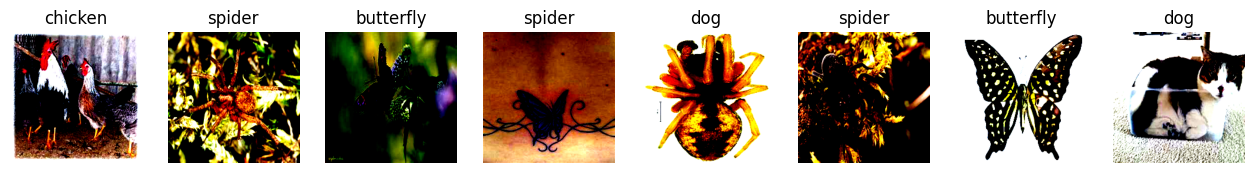

In [22]:
show_predictions(net_18, test_dataloader)

## ResNet-34

In [23]:
net_34 = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes)
net_34 = net_34.to(device)
    
optimizer_34 = torch.optim.Adam(net_34.parameters(), lr=0.001)

In [24]:
# check_model_output(net_34, train_dataloader)

In [25]:
train_test(net_34, 15, train_dataloader,test_dataloader, loss_fn, optimizer_34, save_dir="resnet_34")

Epoch: 0


100%|██████████| 303/303 [00:24<00:00, 12.30it/s]

Train Loss: 
 Avg loss: 2.170955	Accuracy: 23.1%
Test Error: 
 Avg loss: 2.220270	Accuracy: 23.1% 

Epoch: 1



100%|██████████| 303/303 [00:17<00:00, 17.40it/s]

Train Loss: 
 Avg loss: 1.978967	Accuracy: 36.2%
Test Error: 
 Avg loss: 2.102874	Accuracy: 36.2% 

Epoch: 2



100%|██████████| 303/303 [00:32<00:00,  9.40it/s]

Train Loss: 
 Avg loss: 1.738948	Accuracy: 47.0%
Test Error: 
 Avg loss: 1.574349	Accuracy: 47.0% 

Epoch: 3



100%|██████████| 303/303 [00:17<00:00, 17.22it/s]

Train Loss: 
 Avg loss: 1.576668	Accuracy: 48.2%
Test Error: 
 Avg loss: 2.774951	Accuracy: 48.2% 

Epoch: 4



100%|██████████| 303/303 [00:17<00:00, 17.42it/s]

Train Loss: 
 Avg loss: 1.419003	Accuracy: 59.3%
Test Error: 
 Avg loss: 1.197899	Accuracy: 59.3% 

Epoch: 5



100%|██████████| 303/303 [00:34<00:00,  8.67it/s]


Train Loss: 
 Avg loss: 1.302864	Accuracy: 61.7%
Test Error: 
 Avg loss: 1.527325	Accuracy: 61.7% 

Epoch: 6


100%|██████████| 303/303 [00:16<00:00, 17.85it/s]

Train Loss: 
 Avg loss: 1.199276	Accuracy: 65.4%
Test Error: 
 Avg loss: 1.046122	Accuracy: 65.4% 

Epoch: 7



100%|██████████| 303/303 [00:17<00:00, 17.32it/s]

Train Loss: 
 Avg loss: 1.098546	Accuracy: 68.1%
Test Error: 
 Avg loss: 0.941216	Accuracy: 68.1% 

Epoch: 8



100%|██████████| 303/303 [00:17<00:00, 17.17it/s]

Train Loss: 
 Avg loss: 1.029019	Accuracy: 70.0%
Test Error: 
 Avg loss: 0.932748	Accuracy: 70.0% 

Epoch: 9



100%|██████████| 303/303 [00:17<00:00, 16.97it/s]

Train Loss: 
 Avg loss: 0.971935	Accuracy: 67.2%
Test Error: 
 Avg loss: 0.977610	Accuracy: 67.2% 

Epoch: 10



100%|██████████| 303/303 [00:16<00:00, 17.89it/s]


Train Loss: 
 Avg loss: 0.909600	Accuracy: 75.4%
Test Error: 
 Avg loss: 0.754765	Accuracy: 75.4% 

Epoch: 11


100%|██████████| 303/303 [00:23<00:00, 13.00it/s]

Train Loss: 
 Avg loss: 0.870125	Accuracy: 72.5%
Test Error: 
 Avg loss: 0.797831	Accuracy: 72.5% 

Epoch: 12



100%|██████████| 303/303 [00:18<00:00, 16.05it/s]

Train Loss: 
 Avg loss: 0.821795	Accuracy: 76.1%
Test Error: 
 Avg loss: 0.788263	Accuracy: 76.1% 

Epoch: 13



100%|██████████| 303/303 [00:17<00:00, 17.67it/s]

Train Loss: 
 Avg loss: 0.785887	Accuracy: 76.1%
Test Error: 
 Avg loss: 0.726350	Accuracy: 76.1% 

Epoch: 14



100%|██████████| 303/303 [00:16<00:00, 18.18it/s]


Train Loss: 
 Avg loss: 0.746199	Accuracy: 77.3%
Test Error: 
 Avg loss: 0.690890	Accuracy: 77.3% 



{'train_loss': [2.170955468070694,
  1.9789665561387797,
  1.7389482594442014,
  1.5766677392798942,
  1.419003286261287,
  1.3028638741873593,
  1.199276135639156,
  1.098545715286651,
  1.0290189922889532,
  0.97193498941466,
  0.9096000898263358,
  0.8701245259342855,
  0.821794716965847,
  0.7858870570124131,
  0.7461991669297907],
 'train_acc': [22.65193370165746,
  30.830794650694482,
  39.76867868022926,
  45.3864821603759,
  50.76160479165591,
  55.692673103733156,
  58.857850983631955,
  62.49806371663138,
  65.22951412196004,
  66.9076263747612,
  69.22600299478493,
  70.5323488408117,
  72.21046109361285,
  73.5632777404864,
  74.86962358651314],
 'test_loss': [2.220269827952873,
  2.102874044931368,
  1.5743489619528894,
  2.7749513655212454,
  1.1978994918735113,
  1.5273246292037146,
  1.046121682811885,
  0.9412155912162448,
  0.9327481939355926,
  0.9776097077741088,
  0.7547654673801397,
  0.7978309885208362,
  0.7882628644948745,
  0.7263504340507017,
  0.690890268425

Actual Labels: tensor([4, 8, 3, 3, 8, 8, 3, 5, 3, 0, 1, 0, 7, 4, 8, 4]) 
Predicted Labels: tensor([4, 8, 3, 3, 8, 8, 3, 5, 3, 7, 1, 0, 7, 4, 8, 0]) 

Images and their predictions 



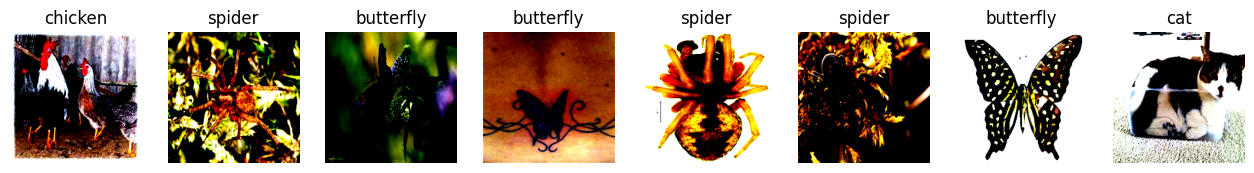

In [26]:
show_predictions(net_34, test_dataloader)

## Pretrained ResNet

In [27]:
from torchvision.models import resnet18, resnet34, ResNet18_Weights, ResNet34_Weights

res_weights = weights=ResNet18_Weights.DEFAULT
# res_weights = weights=ResNet34_Weights.DEFAULT

preprocess = res_weights.transforms()
pretrained_18 = resnet18(weights=res_weights)
# pretrained_18 = resnet34(weights=res_weights)


for param in pretrained_18.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 34.2MB/s]


In [28]:
pretrained_18.fc = nn.Sequential(
                        nn.Linear(pretrained_18.fc.in_features, 256),
                        nn.ReLU(),
                        nn.Linear(256, 10))
# pretrained_18.fc = nn.Linear(pretrained_18.fc.in_features, 10)

pretrained_18 = pretrained_18.to(device)
optimizer_pre18 = torch.optim.Adam(pretrained_18.parameters(), lr=0.001)

In [29]:
train_data = SimpleDataset(train_df, transforms=preprocess, path_col="path", label_col="label_id")
test_data = SimpleDataset(test_df, transforms=preprocess, path_col="path", label_col="label_id")

train_dataloader_18 = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader_18 = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

In [30]:
# check_model_output(pretrained_18, train_dataloader_18)

In [31]:
train_test(pretrained_18, 10, train_dataloader_18,test_dataloader_18, loss_fn, optimizer_pre18, save_steps = 2, save_dir="pt_18")

Epoch: 0


100%|██████████| 303/303 [00:21<00:00, 14.18it/s]

Train Loss: 
 Avg loss: 0.325202	Accuracy: 95.2%
Test Error: 
 Avg loss: 0.151872	Accuracy: 95.2% 

Epoch: 1



100%|██████████| 303/303 [00:21<00:00, 14.12it/s]

Train Loss: 
 Avg loss: 0.220806	Accuracy: 93.8%
Test Error: 
 Avg loss: 0.201594	Accuracy: 93.8% 

Epoch: 2



100%|██████████| 303/303 [00:21<00:00, 13.84it/s]


Train Loss: 
 Avg loss: 0.201756	Accuracy: 95.5%
Test Error: 
 Avg loss: 0.144721	Accuracy: 95.5% 

Epoch: 3


100%|██████████| 303/303 [00:21<00:00, 13.81it/s]

Train Loss: 
 Avg loss: 0.185994	Accuracy: 95.1%
Test Error: 
 Avg loss: 0.149854	Accuracy: 95.1% 

Epoch: 4



100%|██████████| 303/303 [00:21<00:00, 13.80it/s]


Train Loss: 
 Avg loss: 0.182313	Accuracy: 95.8%
Test Error: 
 Avg loss: 0.137198	Accuracy: 95.8% 

Epoch: 5


100%|██████████| 303/303 [00:21<00:00, 13.91it/s]

Train Loss: 
 Avg loss: 0.165720	Accuracy: 95.5%
Test Error: 
 Avg loss: 0.147138	Accuracy: 95.5% 

Epoch: 6



100%|██████████| 303/303 [00:22<00:00, 13.60it/s]


Train Loss: 
 Avg loss: 0.160699	Accuracy: 95.5%
Test Error: 
 Avg loss: 0.146702	Accuracy: 95.5% 

Epoch: 7


100%|██████████| 303/303 [00:22<00:00, 13.73it/s]

Train Loss: 
 Avg loss: 0.158719	Accuracy: 96.1%
Test Error: 
 Avg loss: 0.119978	Accuracy: 96.1% 

Epoch: 8



100%|██████████| 303/303 [00:21<00:00, 13.90it/s]


Train Loss: 
 Avg loss: 0.147045	Accuracy: 95.2%
Test Error: 
 Avg loss: 0.161361	Accuracy: 95.2% 

Epoch: 9


100%|██████████| 303/303 [00:22<00:00, 13.72it/s]


Train Loss: 
 Avg loss: 0.144570	Accuracy: 95.8%
Test Error: 
 Avg loss: 0.142094	Accuracy: 95.8% 



{'train_loss': [0.3252016277680009,
  0.22080592591360498,
  0.20175613776025456,
  0.1859939477995152,
  0.18231285002538633,
  0.16572039542334427,
  0.16069899203840637,
  0.15871904039354404,
  0.14704511580708252,
  0.14456955273008426],
 'train_acc': [89.80740434760159,
  92.85898693654154,
  93.39598285743791,
  94.02592038002788,
  93.93297877833427,
  94.73330923736253,
  94.72814581504622,
  94.71265554809727,
  95.26514173594258,
  95.18769040119791],
 'test_loss': [0.15187187248567371,
  0.20159431336648923,
  0.14472128216618296,
  0.14985357851182685,
  0.13719792225707028,
  0.14713786679443752,
  0.14670167888510663,
  0.1199779948672063,
  0.16136149612755393,
  0.14209358247405748],
 'test_acc': [95.24989673688559,
  93.76290788930194,
  95.47707558859975,
  95.06402313093763,
  95.80751755472944,
  95.53903345724906,
  95.53903345724906,
  96.13795952085916,
  95.24989673688559,
  95.84882280049565]}

Actual Labels: tensor([4, 8, 3, 3, 8, 8, 3, 5, 3, 0, 1, 0, 7, 4, 8, 4]) 
Predicted Labels: tensor([4, 8, 3, 3, 8, 8, 3, 5, 3, 6, 1, 0, 7, 4, 8, 4]) 

Images and their predictions 



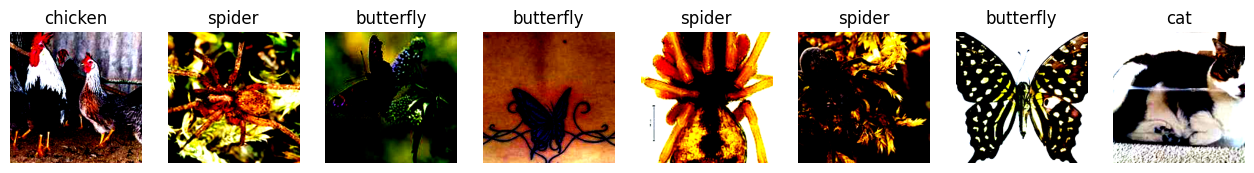

In [32]:
show_predictions(pretrained_18, test_dataloader_18)

## Experiments

In [33]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [34]:
def train_test_1(model, epochs, train_dataloader, test_dataloader, loss_fn, optimizer, writer=None):
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
              }
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        train_loss, train_acc = train_step(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_acc = test_step(test_dataloader, model, loss_fn)
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        print(f"Train Loss: \n {train_loss:>7f}\t\tAccuracy: {(test_acc):>0.1f}%")
        print(f"Test Error: \n Avg loss: {test_loss:>8f}\t\tAccuracy: {(test_acc):>0.1f}% \n")
        
        if writer:
            writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

            writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)

            writer.add_graph(model=model, 
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    if writer:
        writer.close()
    return results

In [35]:
!rm -rf runs 
!rm -rf models

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [36]:
# train_test_1(pretrained_18, 3, train_dataloader_18,test_dataloader_18, loss_fn, optimizer_pre18, writer)

In [37]:
# # %load_ext tensorboard.notebook
# %load_ext tensorboard
# %tensorboard --logdir runs

In [38]:
def create_writer(experiment_name, model_name, extra = None):
    from datetime import datetime
    import os
    
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [39]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [40]:
def save_model(model,target_dir,model_name):

    target_dir_path = pathlib.Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [41]:
def experiment(num_epochs, models, data_portion, train_df, test_df, lrs = [0.001]):
    set_seed(43)
    
    exp_no = 0
    train_df, test_df = train_df[:int(data_portion*len(train_df))], test_df[:int(data_portion*len(train_df))]
    
    for mod in models:
        if mod == "Resnet_18":
            train_data = SimpleDataset(train_df, transforms=train_transforms, path_col="path", label_col="label_id")
            test_data = SimpleDataset(test_df, transforms=test_transforms, path_col="path", label_col="label_id")
            model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=num_classes).to(device)
        elif mod == "Resnet_34":
            train_data = SimpleDataset(train_df, transforms=train_transforms, path_col="path", label_col="label_id")
            test_data = SimpleDataset(test_df, transforms=test_transforms, path_col="path", label_col="label_id")
            model = ResNet(ResidualBlock, [2, 4, 6, 3], num_classes=num_classes).to(device)
        else:
            res_weights = weights=ResNet34_Weights.DEFAULT
            preprocess = res_weights.transforms()
            model = resnet34(weights=res_weights)
            for param in model.parameters():
                param.requires_grad = False
            
            model.fc = nn.Sequential(
                        nn.Linear(model.fc.in_features, 256),
                        nn.ReLU(),
                        nn.Linear(256, 10))
#             model.fc = nn.Linear(model.fc.in_features, 10)

            model = model.to(device)
            
            train_data = SimpleDataset(train_df, transforms=preprocess, path_col="path", label_col="label_id")
            test_data = SimpleDataset(test_df, transforms=preprocess, path_col="path", label_col="label_id")
    
        train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

        test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)
        
        for lr in lrs:
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
            for epoch in num_epochs:
                writer = create_writer(f"{epoch}_epoch_{data_portion}_data_{lr}_lr", mod)
                train_test_1(model, epoch, train_dataloader, test_dataloader, loss_fn, optimizer, writer)
            
                save_filepath = f"{mod}_{epoch}_epochs_{data_portion}_{lr}.pth"
                save_model(model=model, target_dir="models", model_name=save_filepath)

See if the eperimentation works properly with 0.4 percent of data

In [42]:
%%time
# num_epochs = [5, 10]
models = ["Resnet_18", "Resnet_34", "Pretrained_34"]

num_epochs = [4]
# models = ["Resnet_34"]

experiment(num_epochs, models, 0.4, train_df, test_df)

[INFO] Created SummaryWriter, saving to: runs/2024-09-24/4_epoch_0.4_data_0.001_lr/Resnet_18...
Epoch: 0


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 485/485 [00:32<00:00, 12.61it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 303/303 [00:16<00:00, 18.22it/s]


Train Loss: 
 2.150456		Accuracy: 27.0%
Test Error: 
 Avg loss: 2.213213		Accuracy: 27.0% 

Epoch: 1


100%|██████████| 303/303 [00:19<00:00, 15.38it/s]


Train Loss: 
 1.965612		Accuracy: 36.0%
Test Error: 
 Avg loss: 1.864074		Accuracy: 36.0% 

Epoch: 2


100%|██████████| 303/303 [00:29<00:00, 10.26it/s]


Train Loss: 
 1.843291		Accuracy: 40.1%
Test Error: 
 Avg loss: 1.725655		Accuracy: 40.1% 

Epoch: 3


100%|██████████| 303/303 [00:17<00:00, 17.40it/s]


Train Loss: 
 1.740787		Accuracy: 40.7%
Test Error: 
 Avg loss: 1.714278		Accuracy: 40.7% 

[INFO] Created SummaryWriter, saving to: runs/2024-09-24/4_epoch_0.4_data_0.001_lr/Resnet_34...
Epoch: 0


100%|██████████| 303/303 [00:17<00:00, 17.61it/s]


Train Loss: 
 2.229401		Accuracy: 21.1%
Test Error: 
 Avg loss: 2.168653		Accuracy: 21.1% 

Epoch: 1


100%|██████████| 303/303 [00:17<00:00, 17.79it/s]


Train Loss: 
 2.154694		Accuracy: 23.4%
Test Error: 
 Avg loss: 2.137700		Accuracy: 23.4% 

Epoch: 2


100%|██████████| 303/303 [00:22<00:00, 13.77it/s]


Train Loss: 
 2.101350		Accuracy: 27.4%
Test Error: 
 Avg loss: 2.216190		Accuracy: 27.4% 

Epoch: 3


100%|██████████| 303/303 [00:18<00:00, 16.08it/s]


Train Loss: 
 2.019601		Accuracy: 30.5%
Test Error: 
 Avg loss: 2.171947		Accuracy: 30.5% 



Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 205MB/s]


[INFO] Created SummaryWriter, saving to: runs/2024-09-24/4_epoch_0.4_data_0.001_lr/Pretrained_34...
Epoch: 0


100%|██████████| 303/303 [00:24<00:00, 12.60it/s]


Train Loss: 
 0.356494		Accuracy: 95.6%
Test Error: 
 Avg loss: 0.148125		Accuracy: 95.6% 

Epoch: 1


100%|██████████| 303/303 [00:24<00:00, 12.52it/s]


Train Loss: 
 0.200895		Accuracy: 93.9%
Test Error: 
 Avg loss: 0.185835		Accuracy: 93.9% 

Epoch: 2


100%|██████████| 303/303 [00:24<00:00, 12.48it/s]


Train Loss: 
 0.189225		Accuracy: 95.6%
Test Error: 
 Avg loss: 0.137618		Accuracy: 95.6% 

Epoch: 3


100%|██████████| 303/303 [00:23<00:00, 12.63it/s]


Train Loss: 
 0.166197		Accuracy: 95.7%
Test Error: 
 Avg loss: 0.142382		Accuracy: 95.7% 

CPU times: user 5min 9s, sys: 1min 36s, total: 6min 45s
Wall time: 12min 23s


Experiment with learning rate for pretrained model

In [43]:
%%time
models = ["Pretrained_34"]

num_epochs = [10]
lrs = [0.001, 0.0001, 0.0005]

experiment(num_epochs, models, 1, train_df, test_df, lrs=lrs)

[INFO] Created SummaryWriter, saving to: runs/2024-09-24/10_epoch_1_data_0.001_lr/Pretrained_34...
Epoch: 0


100%|██████████| 303/303 [00:24<00:00, 12.18it/s]


Train Loss: 
 0.271503		Accuracy: 95.9%
Test Error: 
 Avg loss: 0.123634		Accuracy: 95.9% 

Epoch: 1


100%|██████████| 303/303 [00:22<00:00, 13.51it/s]


Train Loss: 
 0.193809		Accuracy: 96.0%
Test Error: 
 Avg loss: 0.120522		Accuracy: 96.0% 

Epoch: 2


100%|██████████| 303/303 [00:35<00:00,  8.42it/s]


Train Loss: 
 0.167708		Accuracy: 96.2%
Test Error: 
 Avg loss: 0.120812		Accuracy: 96.2% 

Epoch: 3


100%|██████████| 303/303 [00:22<00:00, 13.76it/s]


Train Loss: 
 0.160802		Accuracy: 96.5%
Test Error: 
 Avg loss: 0.116762		Accuracy: 96.5% 

Epoch: 4


100%|██████████| 303/303 [00:21<00:00, 13.95it/s]


Train Loss: 
 0.153884		Accuracy: 96.5%
Test Error: 
 Avg loss: 0.115754		Accuracy: 96.5% 

Epoch: 5


100%|██████████| 303/303 [00:23<00:00, 12.89it/s]


Train Loss: 
 0.144883		Accuracy: 96.7%
Test Error: 
 Avg loss: 0.114180		Accuracy: 96.7% 

Epoch: 6


100%|██████████| 303/303 [00:26<00:00, 11.31it/s]


Train Loss: 
 0.139520		Accuracy: 96.6%
Test Error: 
 Avg loss: 0.114910		Accuracy: 96.6% 

Epoch: 7


100%|██████████| 303/303 [00:21<00:00, 14.02it/s]


Train Loss: 
 0.128134		Accuracy: 96.8%
Test Error: 
 Avg loss: 0.109281		Accuracy: 96.8% 

Epoch: 8


100%|██████████| 303/303 [00:23<00:00, 12.66it/s]


Train Loss: 
 0.119364		Accuracy: 96.5%
Test Error: 
 Avg loss: 0.128507		Accuracy: 96.5% 

Epoch: 9


100%|██████████| 303/303 [00:21<00:00, 13.87it/s]


Train Loss: 
 0.122156		Accuracy: 96.5%
Test Error: 
 Avg loss: 0.112244		Accuracy: 96.5% 

[INFO] Created SummaryWriter, saving to: runs/2024-09-24/10_epoch_1_data_0.0001_lr/Pretrained_34...
Epoch: 0


100%|██████████| 303/303 [00:34<00:00,  8.81it/s]


Train Loss: 
 0.118247		Accuracy: 96.6%
Test Error: 
 Avg loss: 0.114181		Accuracy: 96.6% 

Epoch: 1


100%|██████████| 303/303 [00:22<00:00, 13.61it/s]


Train Loss: 
 0.113040		Accuracy: 96.7%
Test Error: 
 Avg loss: 0.115118		Accuracy: 96.7% 

Epoch: 2


100%|██████████| 303/303 [00:21<00:00, 13.93it/s]


Train Loss: 
 0.107707		Accuracy: 96.2%
Test Error: 
 Avg loss: 0.136769		Accuracy: 96.2% 

Epoch: 3


100%|██████████| 303/303 [00:21<00:00, 14.23it/s]


Train Loss: 
 0.100625		Accuracy: 96.7%
Test Error: 
 Avg loss: 0.125815		Accuracy: 96.7% 

Epoch: 4


100%|██████████| 303/303 [00:21<00:00, 14.01it/s]


Train Loss: 
 0.092261		Accuracy: 96.7%
Test Error: 
 Avg loss: 0.132054		Accuracy: 96.7% 

Epoch: 5


100%|██████████| 303/303 [00:21<00:00, 13.86it/s]


Train Loss: 
 0.096624		Accuracy: 96.0%
Test Error: 
 Avg loss: 0.153232		Accuracy: 96.0% 

Epoch: 6


100%|██████████| 303/303 [00:40<00:00,  7.47it/s]


Train Loss: 
 0.086827		Accuracy: 96.1%
Test Error: 
 Avg loss: 0.175236		Accuracy: 96.1% 

Epoch: 7


100%|██████████| 303/303 [00:34<00:00,  8.87it/s]


Train Loss: 
 0.088556		Accuracy: 96.8%
Test Error: 
 Avg loss: 0.140634		Accuracy: 96.8% 

Epoch: 8


100%|██████████| 303/303 [00:27<00:00, 11.07it/s]


Train Loss: 
 0.086659		Accuracy: 96.4%
Test Error: 
 Avg loss: 0.136757		Accuracy: 96.4% 

Epoch: 9


100%|██████████| 303/303 [00:23<00:00, 12.86it/s]


Train Loss: 
 0.082922		Accuracy: 96.4%
Test Error: 
 Avg loss: 0.147128		Accuracy: 96.4% 

[INFO] Created SummaryWriter, saving to: runs/2024-09-24/10_epoch_1_data_0.0005_lr/Pretrained_34...
Epoch: 0


100%|██████████| 303/303 [00:22<00:00, 13.44it/s]


Train Loss: 
 0.082252		Accuracy: 96.4%
Test Error: 
 Avg loss: 0.133901		Accuracy: 96.4% 

Epoch: 1


100%|██████████| 303/303 [00:24<00:00, 12.35it/s]


Train Loss: 
 0.077350		Accuracy: 96.1%
Test Error: 
 Avg loss: 0.166660		Accuracy: 96.1% 

Epoch: 2


100%|██████████| 303/303 [00:21<00:00, 14.21it/s]


Train Loss: 
 0.072305		Accuracy: 95.7%
Test Error: 
 Avg loss: 0.195469		Accuracy: 95.7% 

Epoch: 3


100%|██████████| 303/303 [00:22<00:00, 13.70it/s]


Train Loss: 
 0.071806		Accuracy: 96.6%
Test Error: 
 Avg loss: 0.140442		Accuracy: 96.6% 

Epoch: 4


100%|██████████| 303/303 [00:21<00:00, 13.90it/s]


Train Loss: 
 0.066623		Accuracy: 96.3%
Test Error: 
 Avg loss: 0.156474		Accuracy: 96.3% 

Epoch: 5


100%|██████████| 303/303 [00:22<00:00, 13.66it/s]


Train Loss: 
 0.075842		Accuracy: 96.4%
Test Error: 
 Avg loss: 0.167068		Accuracy: 96.4% 

Epoch: 6


100%|██████████| 303/303 [00:22<00:00, 13.75it/s]


Train Loss: 
 0.066781		Accuracy: 97.0%
Test Error: 
 Avg loss: 0.136600		Accuracy: 97.0% 

Epoch: 7


100%|██████████| 303/303 [00:21<00:00, 14.00it/s]


Train Loss: 
 0.070069		Accuracy: 96.6%
Test Error: 
 Avg loss: 0.153379		Accuracy: 96.6% 

Epoch: 8


100%|██████████| 303/303 [00:22<00:00, 13.74it/s]


Train Loss: 
 0.063125		Accuracy: 96.1%
Test Error: 
 Avg loss: 0.171499		Accuracy: 96.1% 

Epoch: 9


100%|██████████| 303/303 [00:23<00:00, 13.10it/s]


Train Loss: 
 0.068141		Accuracy: 96.4%
Test Error: 
 Avg loss: 0.145853		Accuracy: 96.4% 

CPU times: user 15min 45s, sys: 4min 59s, total: 20min 44s
Wall time: 1h 1min 24s


In [44]:
import shutil
shutil.make_archive("runs", 'zip', "/kaggle/working/runs")
shutil.make_archive("model", "zip", "/kaggle/working/models")

'/kaggle/working/model.zip'

## Deployment

In [45]:
# res_weights = weights=ResNet34_Weights.DEFAULT

# preprocess = res_weights.transforms()
# model = resnet34(weights=res_weights)

# model.fc = nn.Sequential(
#                         nn.Linear(model.fc.in_features, 256),
#                         nn.ReLU(),
#                         nn.Linear(256, 10))


In [46]:
# model.load_state_dict(torch.load('/kaggle/working/models/Pretrained_34_10_epochs_0.7.pth', map_location=torch.device('cpu')))

In [47]:
# def predict(img):
#     start_time = timer()
#     img = preprocess(img).unsqueeze(0)
#     model.eval()
#     with torch.inference_mode():
#         pred_probs = torch.softmax(model(img), dim=1)
#     pred_labels_and_probs = {classes[i]: float(pred_probs[0][i]) for i in range(len(classes))}
#     pred_time = round(timer() - start_time, 5)
    
#     return pred_labels_and_probs, pred_time

In [48]:
# test_data_paths = test_df.path.values

# image_path = random.choice(test_data_paths)
# image = Image.open(image_path)

# example_list = list(test_data_paths)[:5]

# print(f"[INFO] Predicting on image at path: {image_path}\n")
# pred_dict, pred_time = predict(img=image)
# print(f"Prediction label and probability dictionary: \n{pred_dict}")
# print(f"Prediction time: {pred_time} seconds")

In [49]:
# try:
#     import gradio as gr
# except: 
#     !pip -q install gradio
#     import gradio as gr
    
# print(f"Gradio version: {gr.__version__}")

In [50]:
# title = "Animals Resnet-34 Classifier"
# description = "Basic Resnet-34 model that classifies animal photos into 10 classes."
# article = "Created at for educational purposes."

# demo = gr.Interface(fn=predict, # mapping function from input to output
#                     inputs=gr.Image(type="pil"), # what are the inputs?
#                     outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
#                              gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
#                     examples=example_list, 
#                     title=title,
#                     description=description,
#                     article=article)

# demo.launch(debug=False,
#             share=True) 